In [1]:
from utils_tools.utils_extension_vis_2d import estimate_true_error_local_max, plot_2D_comparison_with_coverage_error_compare, visualize_selected_points, plot_metrics_table

In [2]:
import torch
from typing import Sequence, Literal, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import pandas as pd

def add_gaussian_noise_xy(  # name kept for drop-in; now supports L-shape with smoothing
    xy: torch.Tensor,                 # (N, 2)
    u: torch.Tensor,                  # (N, 1) or (N,)
    *,
    centers: Sequence[Sequence[float]],
    radii: float | Sequence[float] | Sequence[Sequence[float]],
    sigmas: float | Sequence[float],
    base_sigma: float = 0.0,          # background noise std
    index_eps: float = 1e-6,          # kept for backward-compat; NOT used for idx anymore
    generator: torch.Generator | None = None,
    clamp: tuple[float, float] | None = None,
    return_sigma: bool = False,
    combine: Literal["sum", "max", "quadrature"] = "sum",
    edge_tau: float = 0.05,           # softness of boundary: normalized (islands) or absolute (L-shape)
    # ===== NEW: optional L-shape region =====
    l_shape: Optional[Dict[str, object]] = None,
    # ===== NEW: index controls =====
    l_shape_in_idx: bool = True,     # include L-shape interior in idx if True
    index_margin: float = -0.05,        # <-- DISC/ELLIPSE margin (normalized in d-units)
    l_index_margin: float = -0.1,      # <-- L-SHAPE margin (absolute XY units)
):
    """
    Adds heteroscedastic noise with smoothed regions (islands + optional L-shape).
    - Noise uses soft weights (sigmoid with edge_tau).
    - Indices `idx` are strict geometry with optional margins:
        * Discs/Ellipses: d < 1 - index_margin        (index_margin in normalized radial units)
        * L-shape:        sdf_L < -l_index_margin     (l_index_margin in XY units)
      Set l_shape_in_idx=True to include L-shape in idx.
    """
    # --- shape checks / normalize ---
    if xy.ndim != 2 or xy.shape[1] != 2:
        raise ValueError("xy must have shape (N, 2)")
    u = u.reshape(-1, 1)
    if xy.shape[0] != u.shape[0]:
        raise ValueError("xy and u must have the same number of points (N)")

    device, dtype = u.device, u.dtype
    XY = xy.to(device=device, dtype=dtype)

    # Utility: rectangle signed distance function for axis-aligned box [x0, x1] × [y0, y1]
    def _sdf_rect(xy_: torch.Tensor, x0, x1, y0, y1) -> torch.Tensor:
        x = xy_[:, 0]
        y = xy_[:, 1]
        dx_out = torch.maximum(x0 - x, x - x1).clamp_min(0)
        dy_out = torch.maximum(y0 - y, y - y1).clamp_min(0)
        outside_dist = torch.sqrt(dx_out * dx_out + dy_out * dy_out)
        inside_mask = (x >= x0) & (x <= x1) & (y >= y0) & (y <= y1)
        dist_to_edges = torch.minimum(torch.minimum(x - x0, x1 - x),
                                      torch.minimum(y - y0, y1 - y))
        inside_dist = -dist_to_edges
        return torch.where(inside_mask, inside_dist, outside_dist)

    # Build a list of (weights, amplitudes) from islands and/or L-shape
    W_list = []
    S_list = []

    # -------- Islands (original behavior) --------
    C = torch.as_tensor(centers, dtype=dtype, device=device).reshape(-1, 2)  # (K,2)
    K = C.shape[0]

    d_norm = None   # normalized distance to discs/ellipses (for idx)

    if K > 0:
        # amplitudes per island
        S_islands = (torch.full((K,), float(sigmas), dtype=dtype, device=device)
                     if isinstance(sigmas, (int, float))
                     else torch.as_tensor(sigmas, dtype=dtype, device=device).reshape(-1))
        if S_islands.numel() != K:
            raise ValueError("For islands, sigmas must be scalar or length == len(centers)")

        # radii: scalar, (K,), or (K,2)
        R_raw = torch.as_tensor(radii, dtype=dtype, device=device)
        if R_raw.ndim == 0:
            R_iso = R_raw.expand(K)    # isotropic radius shared by all
            R_aniso = None
        elif R_raw.ndim == 1:
            if R_raw.numel() != K:
                raise ValueError("radii 1D must have length == len(centers)")
            R_iso = R_raw
            R_aniso = None
        elif R_raw.ndim == 2 and R_raw.shape == (K, 2):
            R_iso = None
            R_aniso = R_raw
        else:
            raise ValueError("radii must be scalar, length-K, or shape (K,2) for anisotropic")

        # compute normalized distance and soft weights
        diff = XY[:, None, :] - C[None, :, :]          # (N,K,2)
        tiny = torch.finfo(dtype).tiny
        if R_aniso is None:
            R2 = (R_iso.clamp_min(tiny)) ** 2          # (K,)
            Q  = (diff.pow(2).sum(dim=2)) / R2[None, :]   # (N,K)
        else:
            R2 = (R_aniso.clamp_min(tiny)) ** 2        # (K,2)
            Q  = (diff.pow(2) / R2[None, :, :]).sum(dim=2)  # (N,K)

        d_norm = Q.clamp_min(0).sqrt()                 # normalized radial distance
        tau_norm = max(float(edge_tau), 1e-12)
        w_islands = torch.sigmoid((1.0 - d_norm) / tau_norm).to(dtype)  # (N,K)
        W_list.append(w_islands)
        S_list.append(S_islands)

    # -------- L-shape (NEW) --------
    sdf_L = None  # keep for idx if requested
    if l_shape is not None:
        # Parse parameters
        corner: Tuple[float, float] = tuple(l_shape.get("corner", (0.5, 0.5)))  # inner corner
        lengths: Tuple[float, float] = tuple(l_shape.get("lengths", (0.5, 0.5)))  # (Lx, Ly)
        thickness: float = float(l_shape.get("thickness", 0.2))
        orientation: str = str(l_shape.get("orientation", "NE")).upper()
        # Amplitude for L-shape (falls back to scalar sigmas or first elem)
        if "sigma" in l_shape:
            S_L_val = float(l_shape["sigma"])
        else:
            if isinstance(sigmas, (int, float)):
                S_L_val = float(sigmas)
            else:
                S_L_val = float(torch.as_tensor(sigmas, dtype=dtype).reshape(-1)[0].item())

        cx, cy = corner
        Lx, Ly = lengths
        t = thickness
        if t <= 0 or Lx <= 0 or Ly <= 0:
            raise ValueError("l_shape: thickness and lengths must be positive.")

        # Build rectangles H (horizontal arm) and V (vertical arm)
        if orientation == "NE":
            x0_h, x1_h, y0_h, y1_h = cx, cx + Lx, cy, cy + t
            x0_v, x1_v, y0_v, y1_v = cx, cx + t,  cy, cy + Ly
        elif orientation == "NW":
            x0_h, x1_h, y0_h, y1_h = cx - Lx, cx, cy, cy + t
            x0_v, x1_v, y0_v, y1_v = cx - t,  cx,  cy, cy + Ly
        elif orientation == "SE":
            x0_h, x1_h, y0_h, y1_h = cx, cx + Lx, cy - t, cy
            x0_v, x1_v, y0_v, y1_v = cx, cx + t,  cy - Ly, cy
        elif orientation == "SW":
            x0_h, x1_h, y0_h, y1_h = cx - Lx, cx, cy - t, cy
            x0_v, x1_v, y0_v, y1_v = cx - t,  cx,  cy - Ly, cy
        else:
            raise ValueError("l_shape['orientation'] must be one of {'NE','NW','SE','SW'}.")

        # Signed distance to union of rectangles = min(sdf(H), sdf(V))
        sdf_h = _sdf_rect(XY, x0_h, x1_h, y0_h, y1_h)
        sdf_v = _sdf_rect(XY, x0_v, x1_v, y0_v, y1_v)
        sdf_L = torch.minimum(sdf_h, sdf_v)

        tau_abs = max(float(edge_tau), 1e-12)  # absolute units for L-shape
        w_L = torch.sigmoid(-sdf_L / tau_abs).to(dtype).unsqueeze(1)  # (N,1)
        W_list.append(w_L)
        S_list.append(torch.as_tensor([S_L_val], dtype=dtype, device=device))

    # If neither islands nor L-shape were provided -> background only
    if len(W_list) == 0:
        sigma = torch.full_like(u, float(base_sigma))
        noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
        u_noisy = u + noise
        if clamp is not None:
            lo, hi = clamp
            u_noisy = u_noisy.clamp(min=lo, max=hi)
        idx = torch.zeros(0, dtype=torch.long, device=device)
        return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)

    # Concatenate all contributions and aggregate by rule
    W = torch.cat(W_list, dim=1)                     # (N, M)
    S_all = torch.cat([s.reshape(-1) for s in S_list])  # (M,)

    if combine == "sum":
        add = W * S_all[None, :]                     # (N, M)
        sigma = add.sum(dim=1, keepdim=True) + float(base_sigma)
    elif combine == "max":
        add = W * S_all[None, :]
        sigma = add.max(dim=1, keepdim=True).values + float(base_sigma)
    elif combine == "quadrature":
        add = (W * S_all[None, :]) ** 2
        sigma = (add.sum(dim=1, keepdim=True) + float(base_sigma) ** 2).sqrt()
    else:
        raise ValueError("combine must be one of: 'sum', 'max', 'quadrature'")

    sigma = sigma.clamp_min(0)

    # ====================== IDX CONTROL (customizable margins here) ======================
    # Discs/Ellipses: select strictly inside with optional normalized margin.
    #   threshold_d = 1.0 - index_margin
    #   (index_margin = 0 selects full interior; >0 shrinks the selected core)
    inside_island = torch.zeros(XY.shape[0], dtype=torch.bool, device=device)
    if K > 0:
        thr = 1.0 - float(index_margin)   # <<< adjust disc/ellipse margin here
        inside_island = (d_norm < thr).any(dim=1)

    # L-shape: include in idx only if requested; margin is absolute (XY units).
    inside_L = torch.zeros_like(inside_island)
    if (l_shape is not None) and l_shape_in_idx and (sdf_L is not None):
        # Points strictly inside are sdf_L < 0; margin shrinks by requiring sdf_L < -l_index_margin
        inside_L = (sdf_L < -float(l_index_margin))   # <<< adjust L-shape margin here

    # Union depending on what's enabled
    inside_any = inside_island | inside_L
    idx = torch.nonzero(inside_any, as_tuple=False).squeeze(1)
    # ==================== END IDX CONTROL (customizable margins above) ===================

    # Sample and add noise
    noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
    u_noisy = u + noise
    if clamp is not None:
        lo, hi = clamp
        u_noisy = u_noisy.clamp(min=lo, max=hi)

    return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)


In [3]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
# torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D
from utils_tools.utils_tuning import save_plot

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

torch.set_num_threads(4)
# 9743
# 345
seed = 345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 1024  # Number of collocation points

data_noise = 0.05
N_train = 300
N_test = 2000 # 5000
N_calib = 100


N_total= N_train+N_test+N_calib

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)

# Not involved in numerical experiment
N_valid = 200
X_validation, Y_validation= pde.data_generation(N_valid, data_noise)
X_vis, Y_vis = pde.data_generation(N_total, data_noise)

# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(n=20, step=0.05)

alpha = 0.05

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()



# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 500)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 500
g  = torch.Generator().manual_seed(seed)


# Define printing grid
grid_test, u = pde.solution_field_on_grid(n_grid, source="true", flatten=True)
u_noisy, sigma, id_grid = add_gaussian_noise_xy(
    grid_test, u,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.55],
    base_sigma=0.05, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.55),
    edge_tau=0.1
)

Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()

Y_train, sigma_train, id_train = add_gaussian_noise_xy(
    X_train, Y_train_clean,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.55],
    base_sigma=0.00, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.55),
    edge_tau=0.1
)
Y_test, sigma_test, id_test = add_gaussian_noise_xy(
    X_test, Y_test_clean,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.55],
    base_sigma=0.00, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.55),
    edge_tau=0.1
)
Y_calibration, sigma_calibration, id_calibration = add_gaussian_noise_xy(
    X_calibration, Y_cal_clean,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.55],
    base_sigma=0.00, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.55),
    edge_tau=0.1
)


save_plot(
    plot_truth_and_samples_2D,
    save_dir="2D_AllenCahn", prefix="2D_AllenCahn_data",
)(
    X_test, Y_test, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu


<Figure size 640x480 with 0 Axes>

In [4]:

import torch
from typing import Sequence, Literal
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_table(
    X_test: torch.Tensor,
    cp_uncal_predset,
    cp_cal_predset,
    true_solution,
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df1_name: str="Uncalibrated",
    df2_name: str="Calibrated",
    title: str = "",
    main_title: str | None = None,
    X_vis=None, Y_vis=None,
    alpha_level: float = 0.05,
    figsize: tuple = (9, 2.5),
    max_digits_display = lambda x: f"{x:.4g}"
):
    """
    Display a side-by-side metrics comparison (table) for the uncalibrated and
    calibrated models at a single alpha level.
    """
    # Compute the coverage deviation using mae
    def prepare_coverage_data(df):
        expected = 1 - df["alpha"]
        empirical = df["coverage"]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        sort_idx = exp_full.argsort()
        exp_sorted, emp_sorted = exp_full[sort_idx], emp_full[sort_idx]
        return exp_sorted.to_numpy(), emp_sorted.to_numpy()

    def coverage_deviation(exp, emp, how="mae"):
        diff = np.abs(emp - exp)
        if   how == "mae":  return diff.mean()
        elif how == "rmse": return np.sqrt((diff**2).mean())
        elif how == "max":  return diff.max()
        else:
            raise ValueError("metric must be 'mae', 'rmse', or 'max'")

    exp1, emp1 = prepare_coverage_data(df1)
    exp2, emp2 = prepare_coverage_data(df2)
    dev1 = coverage_deviation(exp1, emp1)  # Using the default metrics
    dev2 = coverage_deviation(exp2, emp2)  # Using the default metrics
    print(f"Uncal dev:{dev1}")
    print(f"Cal dev:{dev2}")
    alpha_level_upper = alpha_level + 1e-3
    alpha_level_lower = alpha_level - 1e-3
    
    # ────────────────────── 1. Slice the two rows ──────────────────────
    row_uncal = df1.loc[(df1["alpha"] <= alpha_level_upper) & 
                           (df1["alpha"] >= alpha_level_lower)].copy()
    row_uncal["model"] = df1_name
    row_uncal["expected coverage"] = (1 - row_uncal["alpha"])
    row_uncal["mean coverage deviation"] = "{:.4f}".format(dev1)
    row_uncal["coverage"] = (row_uncal["coverage"]).map("{:.2f}".format)

    row_cal = df2.loc[(df2["alpha"] <= alpha_level_upper) & 
                        (df2["alpha"] >= alpha_level_lower)].copy()
    row_cal["model"] = df2_name
    row_cal["expected coverage"] = (1- row_cal["alpha"])
    row_cal["mean coverage deviation"] = "{:.4f}".format(dev2)
    row_cal["coverage"] = (row_cal["coverage"]).map("{:.2f}".format)

    if row_uncal.empty or row_cal.empty:
        raise ValueError(f"alpha={alpha_level} not found in both data frames.")

    # ───────────────────── 2. Stack & tidy up ──────────────────────────
    rows = pd.concat([row_uncal, row_cal], axis=0).reset_index(drop=True)
    rows = rows.rename(columns={"coverage": "actual coverage"})
    # Get all columns except 'model' for the selection
    other_cols = [c for c in rows.columns if c != "model"]
    rows = rows.loc[:, ["model"] + other_cols]

    
    # nice ordering: model | expected alpha | true alpha | <metrics…>
    metric_cols = [c for c in rows.columns if c not in ("model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness")]
    rows = rows[["model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness"]]
    

    # ──────────────── 2.5. Format numeric values ───────────────────────
    # Format all numeric columns to 4 decimal places (excluding 'model' column)
    for col in rows.columns:
        if pd.api.types.is_numeric_dtype(rows[col]):
            rows[col] = rows[col].apply(max_digits_display)  # .4g gives up to 4 significant 

    # ───────────────────── 3. Plot as table ────────────────────────────
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    table = ax.table(
        cellText=rows.values,
        colLabels=rows.columns,
        loc="center",
        cellLoc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.25)

    if main_title is not None:
        plt.title(main_title, pad=20, fontsize=12)

    plt.tight_layout()


In [5]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=40)

# Training

In [6]:
import matplotlib.colors as mcolors
# Define color map
colors = ["#2989ff","#ffffff", "#ff424f"]
my_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

colors = ["#8c52ff","#ffffff", "#ff66c4"]
my_cmap_2 = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)


# Feature Distance model

In [7]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}
raw_heuristic = "feature"
# CP-Model
k=30
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":raw_heuristic,
    "n_samples":k
}

dist_feat_pinn = DistanceUQPINN(**model_args)

In [8]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=4500,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=k,
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=2.93e+02 | lr=1.0e-03
ep   500 | L=1.65e-01 | lr=1.0e-03
ep  1000 | L=6.56e-02 | lr=1.0e-03
ep  1500 | L=4.89e-02 | lr=1.0e-03
ep  2000 | L=4.37e-02 | lr=1.0e-03
ep  2500 | L=4.13e-02 | lr=1.0e-03
ep  3000 | L=3.99e-02 | lr=1.0e-03
ep  3500 | L=3.91e-02 | lr=1.0e-03
ep  4000 | L=3.85e-02 | lr=1.0e-03
ep  4500 | L=3.81e-02 | lr=1.0e-03


In [9]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

# CP

In [10]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":k
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

# Local CP

In [11]:
# CP Model (Adaptive)

# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":5000, "gamma":0.5}
quantile_net_config={
    "conf_nn_hidden_layers":(16, 32, 64, 64,64, 64, 64, 32, 16),
    "conf_nn_lr":1.7e-4,  # 2, 1
    "conf_nn_epochs":24000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    **quantile_net_config
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


# Plot the results

(<Figure size 2200x500 with 5 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x'>,
        <Axes: xlabel='x'>, <Axes: xlabel='x'>], dtype=object))

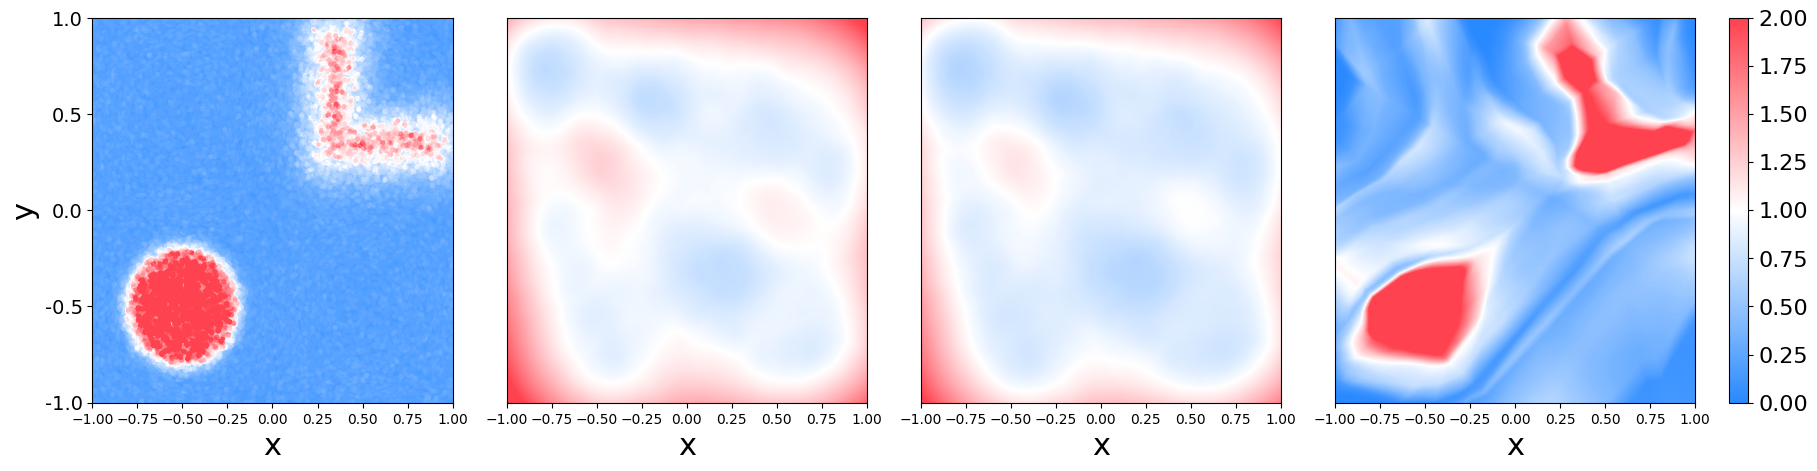

In [12]:
plot_2D_comparison_with_coverage_error_compare(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    y_tick_step=0.5,
    grid_size=500
)

# df1=cp_df_local_smooth
# df2=adap_df_local_smooth
# cp_df_local, #<--
# adap_df_local, #<--

In [13]:
from utils_tools.utils_tuning import save_plot

save_plot(
    plot_2D_comparison_with_coverage_error_compare,
    save_dir="Local_CP_2D",
    prefix="2oddshap"
)(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    y_tick_step=0.5,
    grid_size=500
)

<Figure size 640x480 with 0 Axes>

# Test across the alpha grid

In [14]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid_2d_ac, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas




cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    **quantile_net_config
}
cp_df_local = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)




Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:32<09:49, 32.74s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:04<09:08, 32.26s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:35<08:28, 31.77s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:07<07:55, 31.68s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [02:39<07:27, 31.94s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [03:11<06:53, 31.77s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [03:42<06:19, 31.61s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [04:13<05:46, 31.48s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [04:45<05:15, 31.53s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [05:17<04:44, 31.59s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [05:49<04:13, 31.70s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [06:21<03:42, 31.85s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [06:53<03:11, 31.88s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [07:25<02:40, 32.09s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [08:00<02:11, 32.76s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [08:33<01:38, 32.91s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [09:05<01:05, 32.70s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [09:38<00:32, 32.68s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [10:10<00:00, 32.14s/it]


Uncal dev:0.2771317892308746
Cal dev:0.04775747461687951


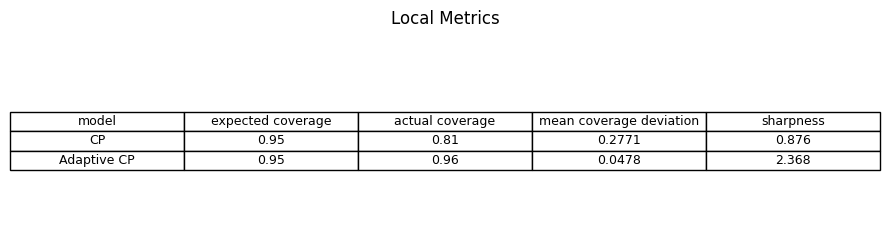

In [15]:
plot_metrics_table(None,None,None,None,cp_df_local,adap_df_local,"CP" ,"Adaptive CP", alpha_level=0.05, 
  main_title="Local Metrics"
)


In [16]:
# Global Metrics

# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas

cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    **quantile_net_config
}
cp_df_global = cp_test_uncertainties(**cp_testing_args)
adap_df_global = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:32<09:37, 32.11s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:03<09:02, 31.91s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:35<08:29, 31.82s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:06<07:52, 31.48s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [02:37<07:19, 31.38s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [03:08<06:47, 31.32s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [03:39<06:14, 31.18s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [04:10<05:41, 31.09s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [04:41<05:10, 31.02s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [05:12<04:39, 31.04s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [05:43<04:08, 31.03s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [06:14<03:37, 31.09s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [06:45<03:06, 31.01s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [07:16<02:35, 31.05s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [07:47<02:04, 31.00s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [08:18<01:32, 30.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [08:49<01:01, 30.93s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [09:20<00:30, 30.92s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [09:51<00:00, 31.12s/it]


Uncal dev:0.03685713506170681
Cal dev:0.024904762705167133


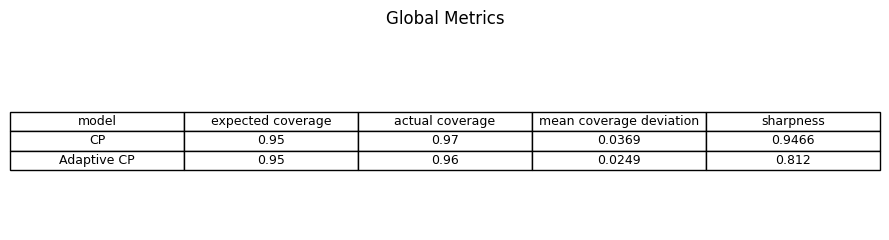

In [17]:
df1=cp_df_global
df2=adap_df_global
df1_name="CP" 
df2_name="Adaptive CP"

plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Global Metrics"
)

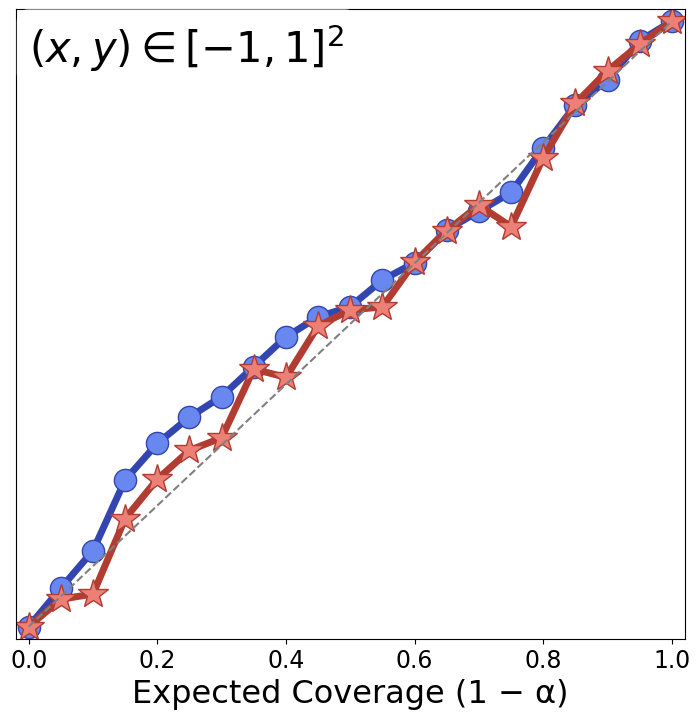

<Figure size 640x480 with 0 Axes>

In [18]:
def plot_coverage_single(
    name_dfpair,
    *,
    labels=("CP", "Local CP"),
    figsize=(7, 7.5),
    suptitle=None,
    model_title_size=28,
    float_label="$x \in \{x:c=(0,0), r=0.2\}$",
):
    """
    Plot a single coverage curve plot (no subplots).

    Parameters
    ----------
    name_dfpair : tuple
        (name, df_uncal, df_cal), where each df has 'alpha' and 'coverage' columns.
    labels : tuple(str, str)
        Legend labels for the two curves (uncal vs cal).
    figsize : tuple
        Figure size.
    suptitle : str | None
        Optional overall figure title.
    model_title_size : int
        Title fontsize for the subplot.
    float_label : tuple(str, str)
        Floating labels to place at top-left corner of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    name, df_uncal, df_cal = name_dfpair

    plt.figure(figsize=figsize)

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)

    plt.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
                     ms=16, lw=5, label=labels[1])
    plt.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=22, lw=5, label=labels[0])
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # # floating label
    # if float_label[0]:
    #     plt.text(
    #         0.02, 0.98, float_label[0],
    #         transform=plt.gca().transAxes,
    #         fontsize=22, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # if float_label[1]:
    #     plt.text(
    #         0.02, 0.90, float_label[1],
    #         transform=plt.gca().transAxes,
    #         fontsize=16, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # plt.text(
    #         0.02, 0.98, "Global",
    #         transform=plt.gca().transAxes,
    #         fontsize=28, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    plt.text(
            0.02, 0.98, float_label,
            transform=plt.gca().transAxes,
            fontsize=30, fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    plt.xlabel("Expected Coverage (1 − α)", fontsize=23)
    # plt.ylabel("Empirical Coverage", fontsize=18)
    # plt.title(name, fontsize=model_title_size, fontweight="bold")
    plt.margins(x=0.02, y=0.02)
    plt.yticks([])
    # plt.xticks([])
    # plt.legend(loc="lower right", fontsize=14, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='both', labelsize=17)
    return plt


pairs = ("Scenario B", cp_df_global,    adap_df_global)


plot_coverage_single(
    pairs,
    float_label=r"$(x,y) \in [-1, 1]^2$"
)
plt.show()

save_plot(
    plot_coverage_single,
    save_dir="Local_CP_2D",
    prefix="cov_C_global"
)(
    pairs,
    float_label=r"$(x,y) \in [-1, 1]^2$"
)



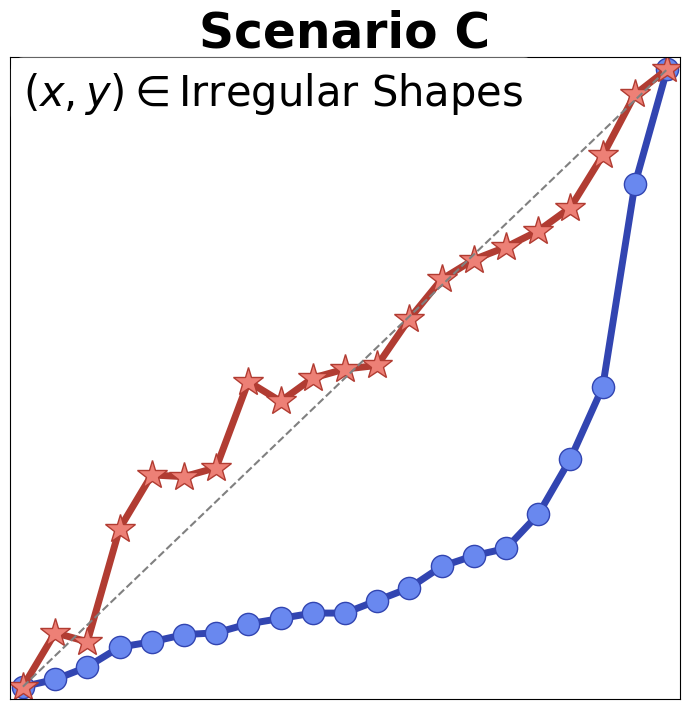

<Figure size 640x480 with 0 Axes>

In [19]:
def plot_coverage_single(
    name_dfpair,
    *,
    labels=("CP", "Local CP"),
    figsize=(7, 7.5),
    suptitle=None,
    model_title_size=35,
    float_label="$x \in \{x:c=(0,0), r=0.2\}$",
):
    """
    Plot a single coverage curve plot (no subplots).

    Parameters
    ----------
    name_dfpair : tuple
        (name, df_uncal, df_cal), where each df has 'alpha' and 'coverage' columns.
    labels : tuple(str, str)
        Legend labels for the two curves (uncal vs cal).
    figsize : tuple
        Figure size.
    suptitle : str | None
        Optional overall figure title.
    model_title_size : int
        Title fontsize for the subplot.
    float_label : tuple(str, str)
        Floating labels to place at top-left corner of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    name, df_uncal, df_cal = name_dfpair

    plt.figure(figsize=figsize)

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)

    plt.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
                     ms=16, lw=5, label=labels[1])
    plt.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=22, lw=5, label=labels[0])
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # # floating label
    # if float_label[0]:
    #     plt.text(
    #         0.02, 0.98, float_label[0],
    #         transform=plt.gca().transAxes,
    #         fontsize=22, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # if float_label[1]:
    #     plt.text(
    #         0.02, 0.90, float_label[1],
    #         transform=plt.gca().transAxes,
    #         fontsize=16, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # plt.text(
    #         0.02, 0.98, "Local",
    #         transform=plt.gca().transAxes,
    #         fontsize=28, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    plt.text(
            0.02, 0.98, float_label,
            transform=plt.gca().transAxes,
            fontsize=30, fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    # plt.xlabel("Expected Coverage (1 − α)", fontsize=23)
    # plt.ylabel("Empirical Coverage", fontsize=18)
    plt.title(name, fontsize=model_title_size, fontweight="bold")
    plt.margins(x=0.02, y=0.02)
    plt.yticks([])
    plt.xticks([])
    # plt.legend(loc="lower right", fontsize=14, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='both', labelsize=17)
    return plt

pairs = ("Scenario C", cp_df_local,    adap_df_local)


plot_coverage_single(
    pairs,
    float_label=r"$(x,y) \in \mathrm{Irregular\ Shapes}$"
)


save_plot(
    plot_coverage_single,
    save_dir="Local_CP_2D",
    prefix="cov_C_local"
)(
    pairs,
    float_label=r"$(x,y) \in \mathrm{Irregular\ Shapes}$"
)



In [20]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=55)


In [21]:

save_plot(
    plot_2D_comparison_with_coverage_error_compare,
    save_dir="Local_CP_2D",
    prefix="2lett"
)(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0),
    # noisy_mask=id_grid, 
    x_tick_step=0.5, y_tick_step=0.5,      # major ticks every 0.1
    grid_size=500
)

<Figure size 640x480 with 0 Axes>

(<Figure size 2200x500 with 5 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x'>,
        <Axes: xlabel='x'>, <Axes: xlabel='x'>], dtype=object))

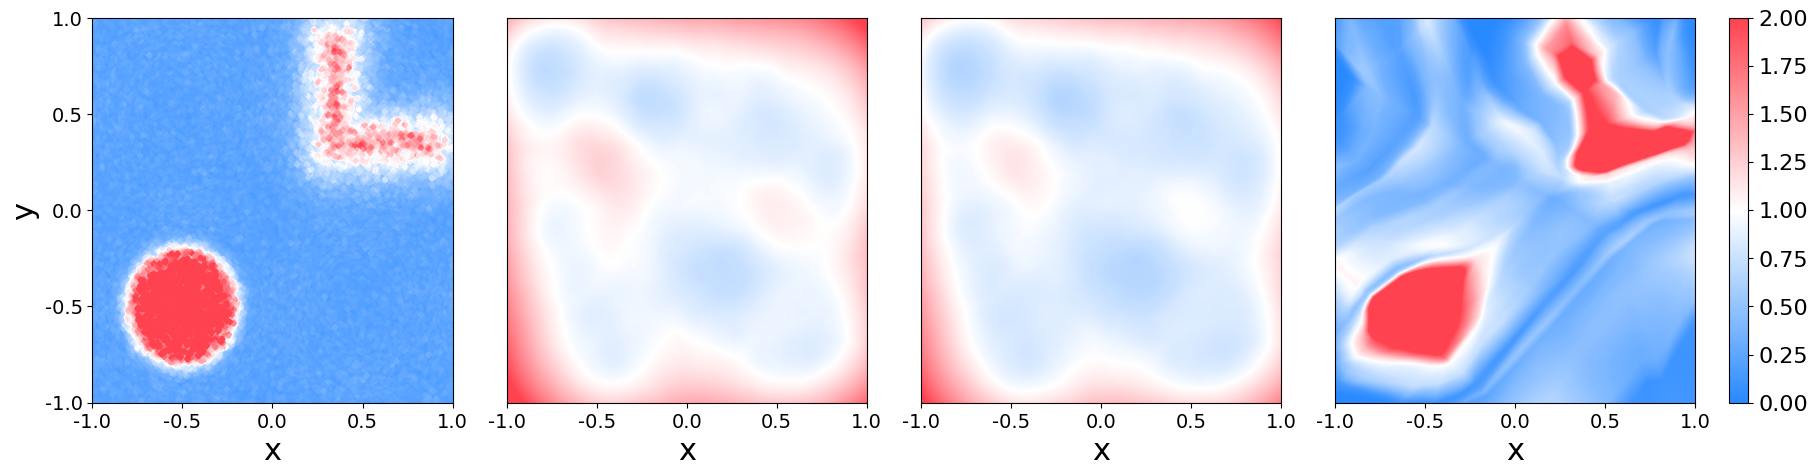

In [22]:
plot_2D_comparison_with_coverage_error_compare(
    grid_test,
    err_est_noise, # 2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2),
    # noisy_mask=id_grid, 
    x_tick_step=0.5, y_tick_step=0.5,      # major ticks every 0.1
    grid_size=500
)